# STROJNO UČENJE - PROJEKT
## EDA Student Performance Dataset
### Predviđanje uspjeha učenika pomoću demografskih i socio-ekonomskih informacija

# Sadržaj
[Library Import](#Library-import)

[Vizualizacija podataka](#Vizualizacija-podataka)

- [Kategoričke varijable](#Kategoričke-značajke)

- [Numeričke varijable](#Numeričke-značajke)

- [Usporedba spola](#Usporedba-spola)


[Feature Selection](#Feature-selection-&-encoding)

[Modeli](#Modeli)
- [Priprema podataka](#Priprema-podataka)

    -[Label Encoding](#Label-encoding)
    
    -[Train-test Split](#Train-Test-Split)

- [Regresija](#Modeli-linearne-regresije)

    -[Linearna Regresija](#Linearna-regresija)
    
    -[Lasso](#MultitaskLasso-Regresija-(3-izlaza))
    
    -[Ridge](#Ridge-regresija)
   
- [Slučajne šume](#slučajne-šume)

# Library import

In [1]:
#%% Imports


#SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection 

import squarify
from sklearn.pipeline import Pipeline


# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
import sklearn.metrics
from sklearn.metrics import *

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge
# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')



# Import dataseta

In [2]:
df = pd.read_csv('StudentsPerformance.csv')

df['AVERAGE'] = df[['math score', 'reading score','writing score']].mean(axis=1)

# Vizualizacija podataka

In [3]:

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,AVERAGE
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


Skup podataka sastoji se od 8 stupaca i 1000 redaka, odnosno podataka o studentima:

In [4]:
df.shape

(1000, 9)

## Kategoričke značajke

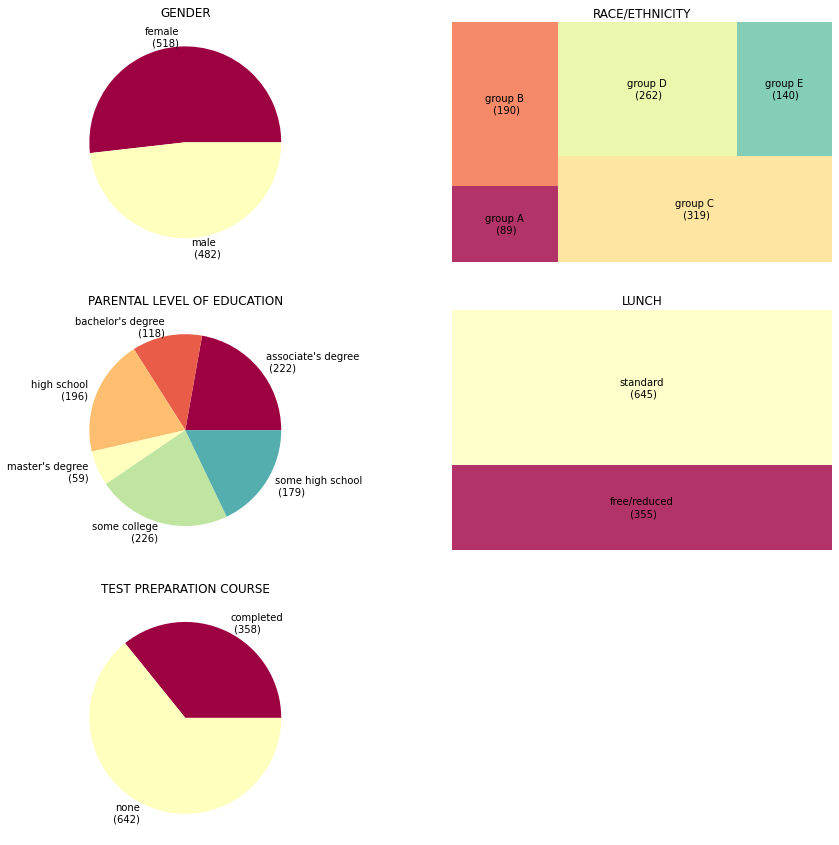

In [5]:
f, axes=plt.subplots(3, 2, figsize=(15, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    
    df_grouped= df.groupby(df.columns[i]).size().reset_index(name='counts')
    labels = df_grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_grouped['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
    
    if i % 2 == 1:
       squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
    else:
        plt.pie(sizes, labels=labels, colors=colors)
    plt.title(df.columns[i].upper())
    plt.axis('off')
    
plt.subplot(3, 2, 6)
plt.axis('off')
plt.show()

## Swarmplot kategoričkih atributa po oznaci,tj. broju bodova

<AxesSubplot:xlabel='parental level of education', ylabel='AVERAGE'>

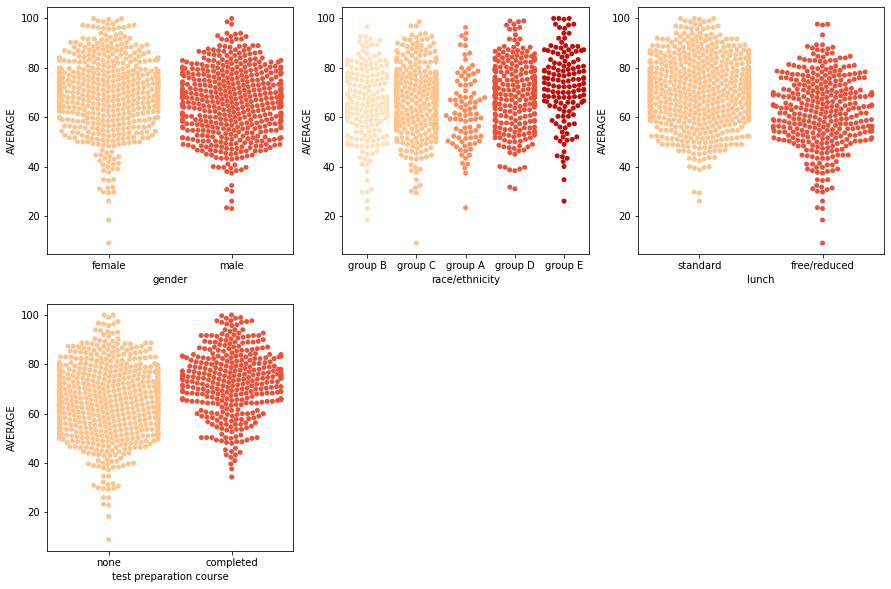

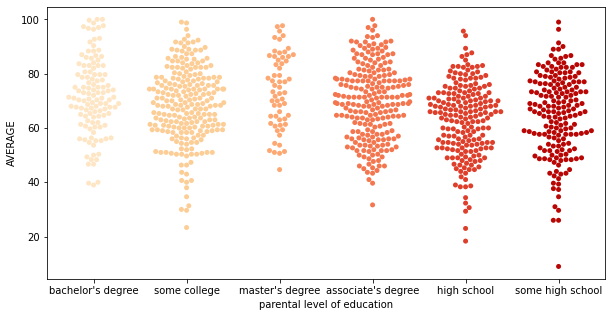

In [6]:
table=df.copy()
table = table.drop(["math score","reading score","writing score","AVERAGE","parental level of education"],axis = 'columns') 

plt.figure(figsize=(15,10))
for indx,val in enumerate(table.columns):
    plt.subplot(2,3,indx+1)
    sns.swarmplot(x=df[val],y=df['AVERAGE'],palette='OrRd')

plt.figure(figsize=(10,5))
sns.swarmplot(x=df['parental level of education'],y=df['AVERAGE'],palette='OrRd')
    

## Numeričke značajke

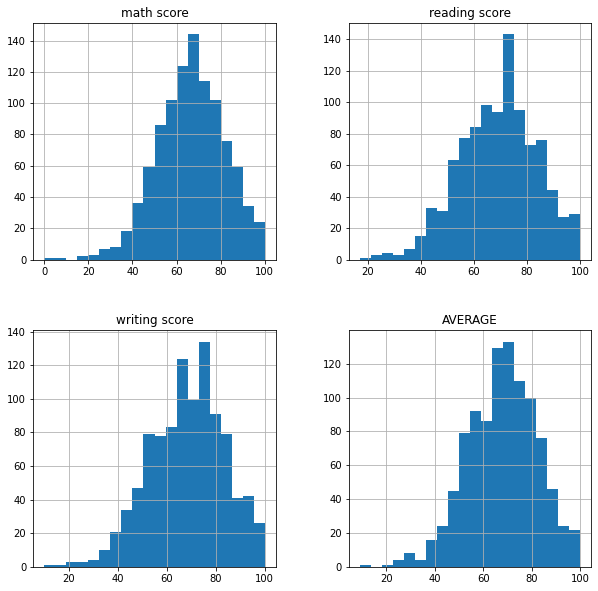

In [7]:
df.hist(figsize=(10,10),bins = 20)
plt.show()

# Feature selection & encoding

## Kodiranje atributa

Moramo napraviti preinake u našim podacima. Točnije, smetaju nam kategoričke varijable pošto algoritmi strojnog učenja ne rade sa kategoričkim varijablama. Postoji više pristupa tom problemu: 

    - One Hot Encoding (funkcija get_dummies)
    - Biblioteka LabelEncoder
    - Ručno, pomoću funkcije replace
    
Referenca: https://pbpython.com/categorical-encoding.html

In [8]:
# moramo napraviti label encoding
# pogledajmo prvo koje su nam vrijednosti u svakom stupcu
for col in df:
    if col == 'math score':
        break
    print(col, ' --> ', df[col].unique())

gender  -->  ['female' 'male']
race/ethnicity  -->  ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education  -->  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch  -->  ['standard' 'free/reduced']
test preparation course  -->  ['none' 'completed']


In [9]:
def find_and_replace(data):
    cleanup_nums = {
        'gender': { "female": 0, 'male': 1 },
        'race/ethnicity': { 'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4 },
        'parental level of education': { 'some high school': 0, 'high school': 1,
                                        "associate's degree": 2, 'some college': 3,
                                        "bachelor's degree": 4, "master's degree": 5,  },
        'lunch': { 'standard': 0, 'free/reduced': 1 },
        'test preparation course': { 'none': 0, 'completed': 1 },
    }
    return df.replace(cleanup_nums)

#one hot encoding
def one_hot_encoding(data):
    # we rename first and last columns for scalability, so we dont have to change our code in multiple places
    return pd.get_dummies(data, columns=['gender', 'race/ethnicity', \
                                       'parental level of education', \
                                       'lunch', 'test preparation course'], \
                          drop_first=True) \
            .rename(columns={\
                             'gender_male' : 'gender',\
                             'test preparation course_none' : 'test preparation course'\
                            })




def encode_data(table_input,enc_type="ONEHOT",removeY=True):
    
    table= table_input.copy()
    
    #stupac koji je feature selection odabrao kao najmanje bitan
    
    if removeY:
        table = table.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
    
    
    if enc_type == "ONEHOT":
        table = table.apply(lambda x: x.astype('category')) 
        table = pd.get_dummies(table,drop_first= True)
        return table
        #return one_hot_encoding(table)
        
    elif enc_type == "LABEL":
        categorical_features = table.select_dtypes(['object','category']).columns.to_list()
        labelencoder = LabelEncoder()
        for i in categorical_features:
            table[i] = labelencoder.fit_transform(table[i])
            
        return table
    else:
        return find_and_replace(table)
    
    
    
    
#Kako koristiti:

#X_features_encoded = encode_data(SP_csv_clean,enc_type="ONE HOT")
#X_features_encoded

#X_features_encoded = encode_data(SP_csv_clean,enc_type="LABEL")
#X_features_encoded

## Feature selection

In [10]:
def odaberi(algorithm,k,X_train, y_train,yname="not given"):
    selector = feature_selection.SelectKBest(algorithm, k)
    selector.fit(X_train, y_train)
    scores = -np.log10(selector.pvalues_)
    indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

    plt.figure(figsize=(7,5))
    plt.plot(range(X_train.shape[1]), scores[indices], 'o', color='gray')
    plt.title(f'Univarijantni odabir znacajki za najvaznijih {k_best} znacajki')
    plt.ylabel(f'log p-vrijednosti metode {yname}')
    plt.xlim([-1, X_train.shape[1]])
    plt.xticks(range(X_train.shape[1]), X_train.columns.values[indices], rotation=90)
    plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
    plt.grid(True,linestyle='--')
    plt.tight_layout()

    [ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

    plt.show()

### 1.Odabir encodinga za feature selection : One hot

In [11]:
X_features_encoded = encode_data(df,enc_type="ONEHOT")
Y = df["AVERAGE"]
k_best = int(len(X_features_encoded.columns)*0.8) 

In [12]:
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

y_train_N=y_train_N.astype('int')


### Rezultat s metodom: f_regression

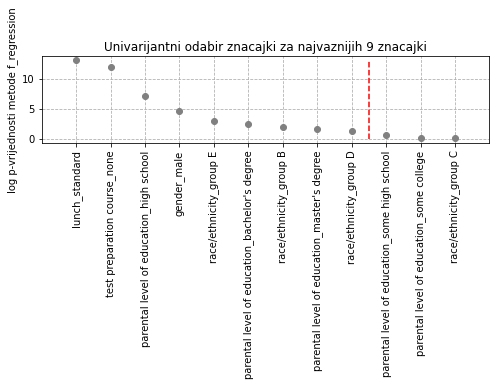

In [13]:
odaberi(feature_selection.f_regression,k_best,X_train_N, y_train_N,yname="f_regression")

### 2.Odabir encodinga za feature selection : Label


In [14]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

k_best = int(len(X_features_encoded.columns)*0.8) 

In [15]:
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

y_train_N=y_train_N.astype('int')

### Rezultat s metodom: f_regression

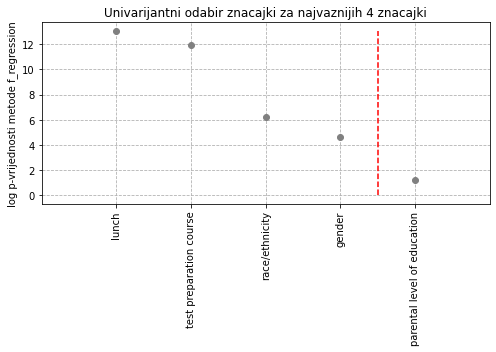

In [16]:
odaberi(feature_selection.f_regression,k_best,X_train_N, y_train_N,yname="f_regression")

Zaključak: 
Maknut ćemo značajku $\text{parental level of education}$, i vidjeti točnost modela bez nje.

# Modeli

Na raspolaganju imamo puno različitih algoritama strojnog učenja koje možemo primjeniti na ovaj problem. Ideja je da prvo krenemo od jednostavnijih, pa nadograđujemo prema onim kompleksnijim modelima. 
Za početak ćemo iskoristiti sljedeće algoritme:
        
        - Algoritmi regresije
        - Support vector machines (SVM)
        - Slučajne šume

## Priprema podataka

### Funkcije za ispis grešaka

In [17]:
def evaluateRegressor(true,predicted,message = "Test set evaluation:"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print(f"R-squared: {R_squared} , from <0,1> ")
    return [MSE,MAE,RMSE,R_squared]

### Train Test Split
Pošto nemamo unaprijed zadane trening i test podatke, uobičajeno je podijeliti cijelu našu bazu u dio za trening i dio za test. Najčešće se koristi sklearn funkcija train_test_split koja prima postotak podataka koji želimo da bude testni. U našem slučaju stavit ćemo 20% (800 trening, 200 test podataka).

    X_features_encoded:    dataset kodiran pomoću odabranog encodinga
    X_features_encoded_FS: isti dataset bez stupca kojeg smo maknuli feature selectionom
    Y:                     skup oznaka (numerički)
    Y_class:               skup oznaka (kategorički, ocjene od 1 do 5) 
    

In [18]:
#KOJI CEMO ENCODING KORISTITI
encoding= "LABEL"

feature_selection_column="lunch"

numeric_cols=["math score","reading score","writing score","AVERAGE"]

In [19]:
Y = df["AVERAGE"]
Y_class= pd.cut(Y,
       5, labels=[1,2,3,4,5])

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(numeric_cols,axis = 'columns'), 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)
#y_train_N=y_train_N.astype('int')

X_train = encode_data(X_train,removeY=False,enc_type=encoding)
X_test = encode_data(X_test,removeY=False,enc_type=encoding)

X_train_FS = X_train.drop([feature_selection_column],axis = 'columns')
X_test_FS = X_test.drop([feature_selection_column],axis = 'columns')


In [20]:
df_temp = df.copy()
df_temp['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
df_temp=df_temp.drop(["AVERAGE"],axis = 'columns')

In [21]:
df2 = one_hot_encoding(df_temp)
train, test = train_test_split(df2, test_size=0.2)
features = train.loc[:, 'gender' : 'test preparation course']
targets = train.loc[:, 'math score' : 'Total score']

Ako ce nam trebat skalirani podaci ,tu su

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Evaluacije spremamo u tablicu

In [23]:
data=[]
data=pd.DataFrame(data, columns=["MSE", "MAE","RMSE", "R^2"])
data.index.astype(str, copy = False)

data

,MSE,MAE,RMSE,R^2


## Modeli linearne regresije

Osnovni algoritam regresije (a i cijele teorije strojnog učenja) je linearna regresija. Osim nje, postoje i neke modifikacije. Svaka ima svoje prednosti i mane, zbog kojih se sve koriste u određenim situacijama. Mi ćemo iskoristiti Lasso i Ridge, te usporediti rezultate svih.

### Linearna Regresija

In [24]:
LinearReg = LinearRegression(normalize = True)
LinearReg = LinearReg.fit(X_train,y_train)

LinearReg_FS = LinearRegression(normalize = True)
LinearReg_FS = LinearReg_FS.fit(X_train_FS,y_train)

predicted_y_test = LinearReg.predict(X_test)
predicted_y_test_FS=LinearReg_FS.predict(X_test_FS)

In [25]:
data.loc['linearna'] = evaluateRegressor(y_test, predicted_y_test)
data.loc['linearna_fs'] = evaluateRegressor(y_test, predicted_y_test_FS)

data

Test set evaluation:
MSE: 141.85587159554157
MAE: 9.469449871790166
RMSE: 11.910326258988105
R-squared: 0.24961098637136292 , from <0,1> 
Test set evaluation:
MSE: 160.35674316139216
MAE: 9.939536428656291
RMSE: 12.663204300704942
R-squared: 0.1517450989081257 , from <0,1> 


,MSE,MAE,RMSE,R^2
linearna,141.855872,9.469450,11.910326,0.249611
linearna_fs,160.356743,9.939536,12.663204,0.151745


### MultitaskLasso Regresija (3 izlaza)

In [26]:
X_lasso =df.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
Y_3_lasso =df[["math score","reading score","writing score"]]

X_lasso = encode_data(X_lasso,enc_type="LABEL",removeY=False)

In [27]:
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(
    X_lasso, 
    Y_3_lasso, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

In [28]:
# import linear model library
from sklearn import linear_model
  
# create MultiTaskLasso model
MTL = linear_model.MultiTaskLasso(alpha = 0.5)

# fit the model to a data
MTL.fit(X_train_lasso,y_train_lasso)

pred=MTL.predict(X_test_lasso)
# perform prediction and print the result
#print("Prediciton result: \n", MTL.predict(X_test_lasso), "\n")
  
#print the coefficients
print("Coefficients: \n", MTL.coef_, "\n")
  
#print the intercepts
print("Intercepts: \n", MTL.intercept_, "\n")
  
#print the number of iterations performed
print("Number of Iterations: ", MTL.n_iter_, "\n")

Coefficients: 
 [[ 4.00290721  2.1417578  -0.28123025  9.26628912 -4.79195658]
 [-5.85232346  1.41015054 -0.38420131  6.02433873 -6.17735526]
 [-7.6133211   1.60976483 -0.49105645  6.85640263 -8.33113575]] 

Intercepts: 
 [57.28913259 69.84042931 70.26941066] 

Number of Iterations:  4 



In [29]:
print("\nScores:")

data.loc['Multi-Lasso'] = evaluateRegressor(y_test_lasso, pred)


Scores:
Test set evaluation:
MSE: 162.92117235098866
MAE: 10.4279036683022
RMSE: 12.75650674277611
R-squared: 0.26072436688821193 , from <0,1> 


## Ridge regresija

Objasnjena varijanca = 0.27
R2 = 0.26
MSE = 152.45


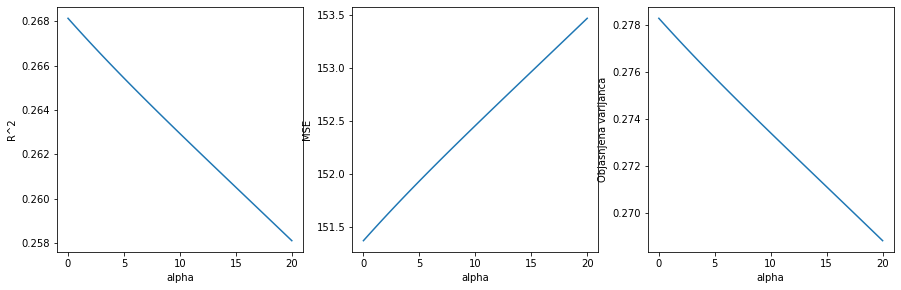

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
alpha_array = np.linspace(0.01, 20.0, 100)
R2 = []
MSE = []
explained_variance = []

correct_scores = test.loc[:, 'math score' : 'Total score']


for alpha in alpha_array:
    model_ridge = Pipeline( [ ('ridge', Ridge(alpha=alpha)) ] )
    model_ridge = model_ridge.fit(features, targets)
    #R2_ridge = model_ridge.score(test.loc[:, 'gender' : 'test preparation course'], correct_scores)
    regr_pred = model_ridge.predict(test.loc[:, 'gender' : 'test preparation course'])
    
    
    explained_variance.append(explained_variance_score(correct_scores, regr_pred))
    R2.append(r2_score(correct_scores, regr_pred))
    MSE.append(mean_squared_error(correct_scores, regr_pred))

def avg(arr):
    return sum(arr) / len(arr)

print('Objasnjena varijanca = '+'{0:.2f}'.format(avg(explained_variance))+'\nR2 = '+'{0:.2f}'.format(avg(R2))+'\nMSE = '+'{0:.2f}'.format(avg(MSE)))


ax[0].plot(alpha_array, R2)
ax[0].set(xlabel='alpha', ylabel='R^2')
ax[1].plot(alpha_array, MSE)
ax[1].set(xlabel='alpha', ylabel='MSE')
ax[2].plot(alpha_array, explained_variance)
ax[2].set(xlabel='alpha', ylabel='Objasnjena varijanca')

plt.show()

## LightGBM

In [31]:
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(X_train,y_train)
LGBMReg_FS = lgb.LGBMRegressor(random_state=0).fit(X_train_FS,y_train)

#predicted_y_train = LGBMReg.predict(X_train)
#evaluateRegressor(y_train,predicted_y_train,"    Training Set")

predicted_y_test = LGBMReg.predict(X_test)
data.loc['LightGBM'] = evaluateRegressor(y_test,predicted_y_test)

predicted_y_test_FS = LGBMReg_FS.predict(X_test_FS)
data.loc['LightGBM_FS'] = evaluateRegressor(y_test,predicted_y_test_FS)


Test set evaluation:
MSE: 161.4669267864057
MAE: 10.043984383817747
RMSE: 12.706963712327415
R-squared: 0.14587245094543977 , from <0,1> 
Test set evaluation:
MSE: 180.90972494460678
MAE: 10.592235739667295
RMSE: 13.450268582619708
R-squared: 0.04302396136221598 , from <0,1> 


### Koji atributi najviše pridonose modelu LightGBM

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

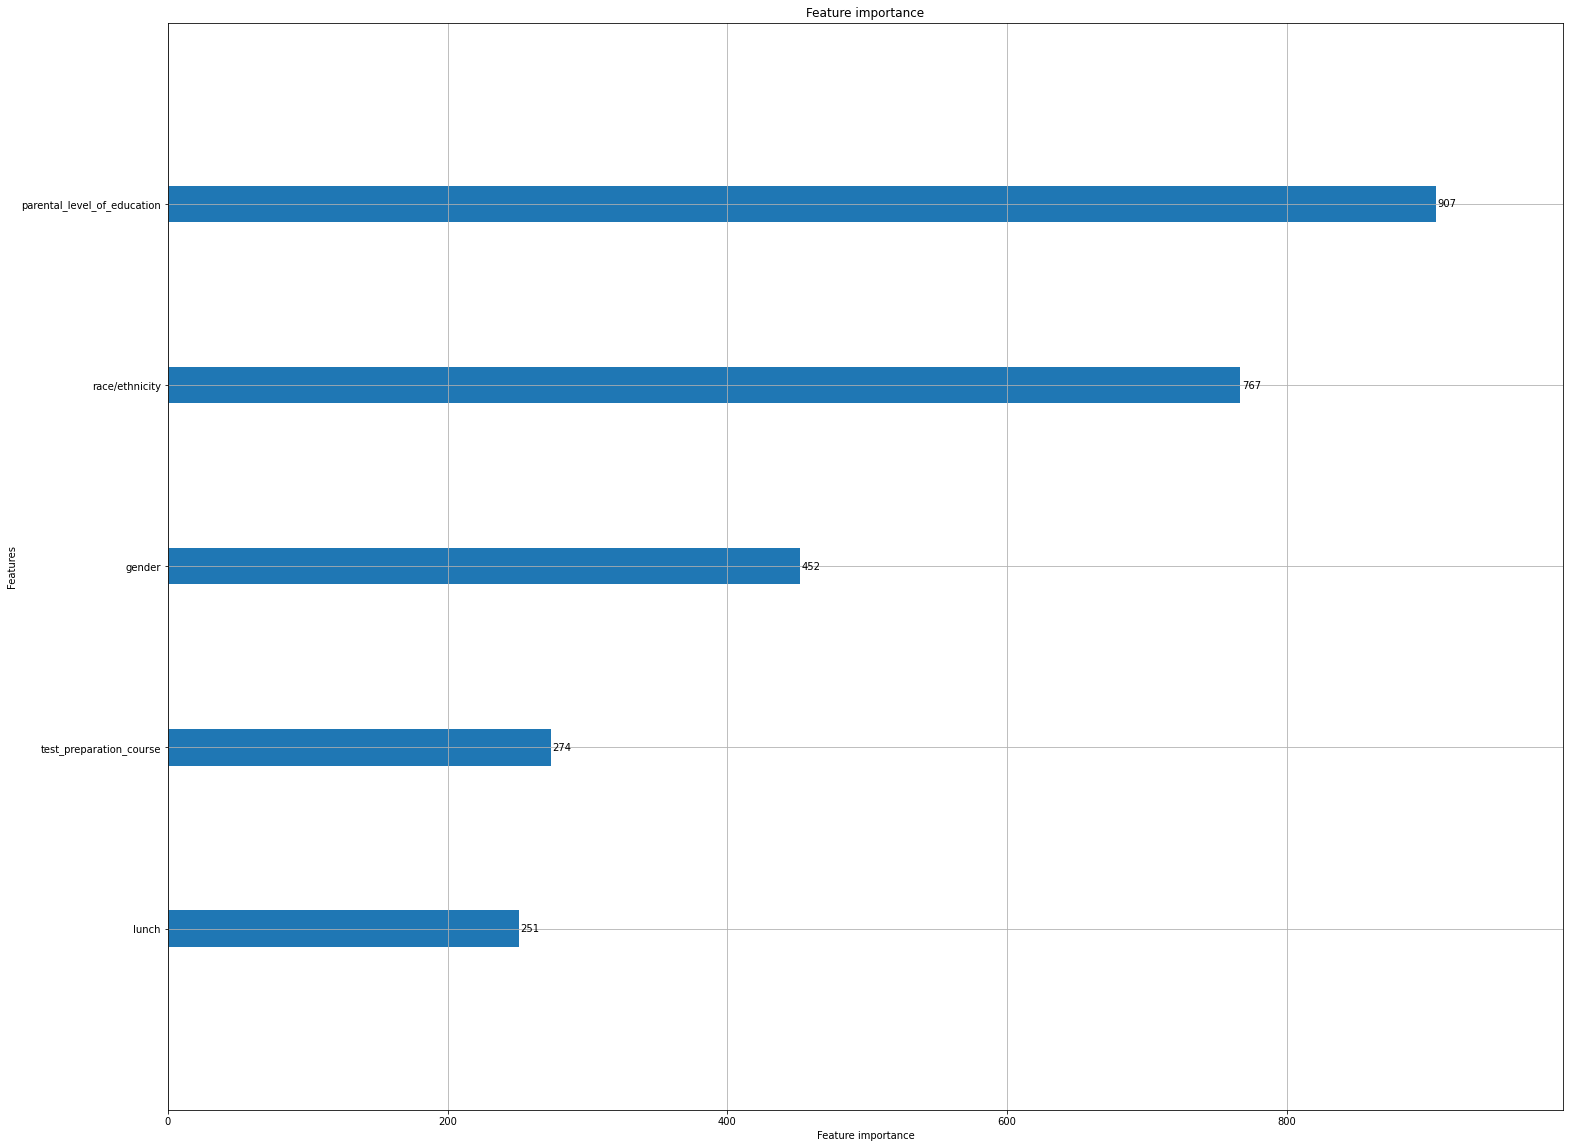

In [32]:
lgb.plot_importance(LGBMReg,figsize=(25,20))

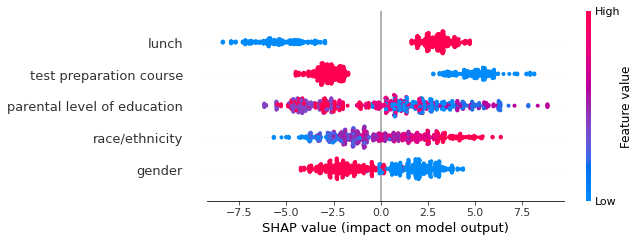

In [62]:
shap_values = shap.TreeExplainer(LGBMReg).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [66]:
X_train.iloc[547]

gender                         0
race/ethnicity                 2
parental level of education    1
lunch                          0
test preparation course        0
Name: 174, dtype: int32

In [71]:
y_train[547]

In [67]:
df.iloc[547]

gender                                male
race/ethnicity                     group C
parental level of education    high school
lunch                             standard
test preparation course          completed
math score                              72
reading score                           67
writing score                           64
AVERAGE                          67.666667
Name: 547, dtype: object

## k Najbližih susjeda (kNN)

In [34]:
from sklearn import neighbors

mse = []
mse_train=[]
maxx=[]
maxx_train=[]
r2=[]
r2_train=[]

for i in range(150):
    i = i+1
    model = neighbors.KNeighborsRegressor(n_neighbors = i)
    model.fit(X_train, y_train) 
    pred=model.predict(X_test) 
    pred_train=model.predict(X_train) 
    
    mse.append(mean_squared_error(y_test,pred)) 
    mse_train.append(mean_squared_error(y_train,pred_train)) 
    
    maxx.append(max_error(y_test,pred)) 
    maxx_train.append(max_error(y_train,pred_train)) 
    
    r2.append(r2_score(y_test,pred)) 
    r2_train.append(r2_score(y_train,pred_train)) 
    
    


In [35]:
mse2=pd.DataFrame({"k": range(1,151),"MSE": mse})
min_index_mse = mse2.iloc[:,1].idxmin()

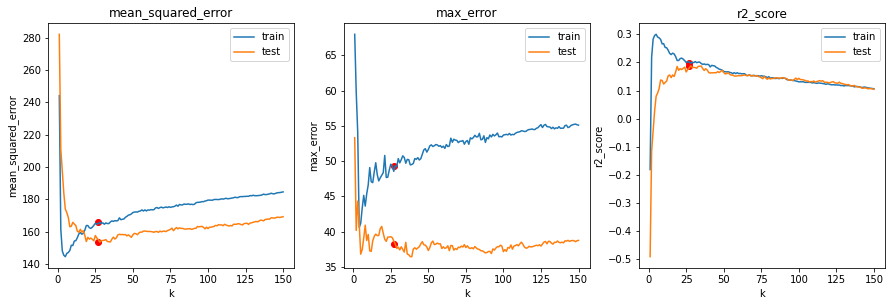

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

train=[mse_train,maxx_train,r2_train]
test=[mse,maxx,r2]
labels=["mean_squared_error","max_error","r2_score"]
titles=["mean_squared_error","max_error","r2_score"]


for i in range(3):
    tr= train[i]
    ts= test[i]
    ylab=labels[i]
    title=titles[i]
    
    ax[i].plot(min_index_mse,tr[min_index_mse],'ro')
    ax[i].plot(min_index_mse,ts[min_index_mse],'ro')
    
    ax[i].plot(np.arange(1,150+1),tr,label='train')
    ax[i].plot(np.arange(1,150+1),ts,label='test')
    
    ax[i].set(xlabel='k')
    ax[i].set(ylabel=ylab)
    ax[i].title.set_text(title)
    ax[i].legend()




plt.show()

### Uzimamo onaj model s najmanjim MSE

In [37]:
model = neighbors.KNeighborsRegressor(n_neighbors =min_index_mse)
model.fit(X_train, y_train) 

model_FS = neighbors.KNeighborsRegressor(n_neighbors = min_index_mse)
model_FS.fit(X_train_FS, y_train) 

pred=model.predict(X_test)
pred_FS=model_FS.predict(X_test_FS)

In [38]:
data.loc['kNN'] = evaluateRegressor(y_test, pred)
data.loc['kNN_FS'] = evaluateRegressor(y_test, pred_FS)

Test set evaluation:
MSE: 155.00865340649293
MAE: 9.817592592592591
RMSE: 12.450247122306164
R-squared: 0.18003541746059637 , from <0,1> 
Test set evaluation:
MSE: 172.19913961286386
MAE: 10.43820987654321
RMSE: 13.122466978920688
R-squared: 0.08910120484672235 , from <0,1> 


## CATBoost

### Pretraživanje hiperparametra: $iterations$

In [39]:
from catboost import CatBoostRegressor

train_data = X_train
eval_data = X_test
train_labels = y_train


k=50

treeScoresTest1=np.zeros(k)
treeScoresTrain1=np.zeros(k)
treeScoresTest2=np.zeros(k)
treeScoresTrain2=np.zeros(k)
treeScoresTest3=np.zeros(k)
treeScoresTrain3=np.zeros(k)

for i in np.arange(1,k+1):
        # Initialize CatBoostRegressor
    model = CatBoostRegressor(iterations=i,
                              learning_rate=1,
                              depth=2)
    # Fit model
    model.fit(train_data, train_labels)
    
    
    treeScoresTrain1[i-1]=r2_score(y_train, model.predict(X_train))
    treeScoresTest1[i-1] =r2_score(y_test, model.predict(X_test))
    treeScoresTrain2[i-1]= max_error(y_train, model.predict(X_train))
    treeScoresTest2[i-1] = max_error(y_test, model.predict(X_test))
    treeScoresTrain3[i-1]= mean_squared_error (y_train, model.predict(X_train))
    treeScoresTest3[i-1] = mean_squared_error (y_test, model.predict(X_test))


0:	learn: 13.2903056	total: 155ms	remaining: 0us
0:	learn: 13.2903056	total: 606us	remaining: 606us
1:	learn: 13.0054013	total: 1.22ms	remaining: 0us
0:	learn: 13.2903056	total: 606us	remaining: 1.21ms
1:	learn: 13.0054013	total: 1.2ms	remaining: 601us
2:	learn: 12.7612942	total: 1.82ms	remaining: 0us
0:	learn: 13.2903056	total: 859us	remaining: 2.58ms
1:	learn: 13.0054013	total: 1.54ms	remaining: 1.54ms
2:	learn: 12.7612942	total: 2.3ms	remaining: 766us
3:	learn: 12.6764159	total: 2.83ms	remaining: 0us
0:	learn: 13.2903056	total: 584us	remaining: 2.34ms
1:	learn: 13.0054013	total: 1.72ms	remaining: 2.58ms
2:	learn: 12.7612942	total: 2.45ms	remaining: 1.63ms
3:	learn: 12.6764159	total: 3.19ms	remaining: 797us
4:	learn: 12.6354106	total: 3.9ms	remaining: 0us
0:	learn: 13.2903056	total: 623us	remaining: 3.12ms
1:	learn: 13.0054013	total: 1.34ms	remaining: 2.68ms
2:	learn: 12.7612942	total: 1.99ms	remaining: 1.99ms
3:	learn: 12.6764159	total: 2.61ms	remaining: 1.3ms
4:	learn: 12.6354106	t

11:	learn: 12.4963490	total: 9.19ms	remaining: 6.13ms
12:	learn: 12.4893986	total: 9.72ms	remaining: 5.24ms
13:	learn: 12.4801419	total: 10.3ms	remaining: 4.4ms
14:	learn: 12.4698043	total: 10.8ms	remaining: 3.6ms
15:	learn: 12.4588340	total: 11.3ms	remaining: 2.84ms
16:	learn: 12.4578937	total: 11.9ms	remaining: 2.1ms
17:	learn: 12.4466047	total: 12.5ms	remaining: 1.39ms
18:	learn: 12.4445938	total: 13ms	remaining: 684us
19:	learn: 12.4355425	total: 13.6ms	remaining: 0us
0:	learn: 13.2903056	total: 815us	remaining: 16.3ms
1:	learn: 13.0054013	total: 1.38ms	remaining: 13.1ms
2:	learn: 12.7612942	total: 2.17ms	remaining: 13ms
3:	learn: 12.6764159	total: 2.7ms	remaining: 11.5ms
4:	learn: 12.6354106	total: 3.23ms	remaining: 10.3ms
5:	learn: 12.5949848	total: 4.25ms	remaining: 10.6ms
6:	learn: 12.5772399	total: 4.88ms	remaining: 9.76ms
7:	learn: 12.5659264	total: 5.86ms	remaining: 9.52ms
8:	learn: 12.5470869	total: 6.51ms	remaining: 8.69ms
9:	learn: 12.5369285	total: 7ms	remaining: 7.7ms
1

22:	learn: 12.4105935	total: 14ms	remaining: 3.67ms
23:	learn: 12.3942289	total: 14.6ms	remaining: 3.05ms
24:	learn: 12.3923607	total: 15.3ms	remaining: 2.44ms
25:	learn: 12.3887219	total: 15.9ms	remaining: 1.83ms
26:	learn: 12.3860257	total: 16.4ms	remaining: 1.22ms
27:	learn: 12.3818732	total: 17ms	remaining: 607us
28:	learn: 12.3779168	total: 17.6ms	remaining: 0us
0:	learn: 13.2903056	total: 629us	remaining: 18.3ms
1:	learn: 13.0054013	total: 1.15ms	remaining: 16.1ms
2:	learn: 12.7612942	total: 1.57ms	remaining: 14.1ms
3:	learn: 12.6764159	total: 2.02ms	remaining: 13.1ms
4:	learn: 12.6354106	total: 2.43ms	remaining: 12.2ms
5:	learn: 12.5949848	total: 2.88ms	remaining: 11.5ms
6:	learn: 12.5772399	total: 3.65ms	remaining: 12ms
7:	learn: 12.5659264	total: 4.21ms	remaining: 11.6ms
8:	learn: 12.5470869	total: 4.79ms	remaining: 11.2ms
9:	learn: 12.5369285	total: 5.32ms	remaining: 10.6ms
10:	learn: 12.5124570	total: 5.94ms	remaining: 10.3ms
11:	learn: 12.4963490	total: 6.5ms	remaining: 9.7

1:	learn: 13.0054013	total: 1.5ms	remaining: 24.7ms
2:	learn: 12.7612942	total: 2.05ms	remaining: 21.9ms
3:	learn: 12.6764159	total: 2.55ms	remaining: 19.8ms
4:	learn: 12.6354106	total: 3.16ms	remaining: 18.9ms
5:	learn: 12.5949848	total: 3.83ms	remaining: 18.5ms
6:	learn: 12.5772399	total: 4.44ms	remaining: 17.8ms
7:	learn: 12.5659264	total: 5.06ms	remaining: 17.1ms
8:	learn: 12.5470869	total: 5.74ms	remaining: 16.6ms
9:	learn: 12.5369285	total: 6.34ms	remaining: 15.9ms
10:	learn: 12.5124570	total: 6.95ms	remaining: 15.2ms
11:	learn: 12.4963490	total: 7.54ms	remaining: 14.5ms
12:	learn: 12.4893986	total: 8.18ms	remaining: 13.8ms
13:	learn: 12.4801419	total: 8.79ms	remaining: 13.2ms
14:	learn: 12.4698043	total: 9.43ms	remaining: 12.6ms
15:	learn: 12.4588340	total: 10.1ms	remaining: 12ms
16:	learn: 12.4578937	total: 10.9ms	remaining: 11.5ms
17:	learn: 12.4466047	total: 11.5ms	remaining: 10.8ms
18:	learn: 12.4445938	total: 12.1ms	remaining: 10.2ms
19:	learn: 12.4355425	total: 12.6ms	rema

0:	learn: 13.2903056	total: 1.67ms	remaining: 67ms
1:	learn: 13.0054013	total: 2.46ms	remaining: 48ms
2:	learn: 12.7612942	total: 3.07ms	remaining: 38.8ms
3:	learn: 12.6764159	total: 3.64ms	remaining: 33.7ms
4:	learn: 12.6354106	total: 4.1ms	remaining: 29.5ms
5:	learn: 12.5949848	total: 4.54ms	remaining: 26.5ms
6:	learn: 12.5772399	total: 5.01ms	remaining: 24.4ms
7:	learn: 12.5659264	total: 5.47ms	remaining: 22.6ms
8:	learn: 12.5470869	total: 5.89ms	remaining: 21ms
9:	learn: 12.5369285	total: 6.31ms	remaining: 19.6ms
10:	learn: 12.5124570	total: 6.78ms	remaining: 18.5ms
11:	learn: 12.4963490	total: 7.21ms	remaining: 17.4ms
12:	learn: 12.4893986	total: 7.62ms	remaining: 16.4ms
13:	learn: 12.4801419	total: 8.04ms	remaining: 15.5ms
14:	learn: 12.4698043	total: 8.46ms	remaining: 14.7ms
15:	learn: 12.4588340	total: 8.92ms	remaining: 13.9ms
16:	learn: 12.4578937	total: 9.34ms	remaining: 13.2ms
17:	learn: 12.4466047	total: 9.89ms	remaining: 12.6ms
18:	learn: 12.4445938	total: 10.3ms	remaining

17:	learn: 12.4466047	total: 10.5ms	remaining: 16.4ms
18:	learn: 12.4445938	total: 11.1ms	remaining: 15.7ms
19:	learn: 12.4355425	total: 11.7ms	remaining: 15.2ms
20:	learn: 12.4295135	total: 12.3ms	remaining: 14.6ms
21:	learn: 12.4155400	total: 12.7ms	remaining: 13.9ms
22:	learn: 12.4105935	total: 13.2ms	remaining: 13.2ms
23:	learn: 12.3942289	total: 13.7ms	remaining: 12.6ms
24:	learn: 12.3923607	total: 14.1ms	remaining: 11.9ms
25:	learn: 12.3887219	total: 14.5ms	remaining: 11.2ms
26:	learn: 12.3860257	total: 15ms	remaining: 10.6ms
27:	learn: 12.3818732	total: 15.5ms	remaining: 9.94ms
28:	learn: 12.3779168	total: 16ms	remaining: 9.39ms
29:	learn: 12.3766589	total: 17.2ms	remaining: 9.15ms
30:	learn: 12.3706264	total: 17.9ms	remaining: 8.67ms
31:	learn: 12.3669856	total: 18.5ms	remaining: 8.09ms
32:	learn: 12.3666080	total: 18.9ms	remaining: 7.46ms
33:	learn: 12.3647803	total: 19.4ms	remaining: 6.84ms
34:	learn: 12.3636232	total: 19.8ms	remaining: 6.24ms
35:	learn: 12.3621623	total: 20.

32:	learn: 12.3666080	total: 15.7ms	remaining: 8.11ms
33:	learn: 12.3647803	total: 16.3ms	remaining: 7.69ms
34:	learn: 12.3636232	total: 17.1ms	remaining: 7.32ms
35:	learn: 12.3621623	total: 19.2ms	remaining: 7.46ms
36:	learn: 12.3597813	total: 19.7ms	remaining: 6.93ms
37:	learn: 12.3581927	total: 20.2ms	remaining: 6.38ms
38:	learn: 12.3553839	total: 20.6ms	remaining: 5.82ms
39:	learn: 12.3519203	total: 21.2ms	remaining: 5.3ms
40:	learn: 12.3514296	total: 21.7ms	remaining: 4.76ms
41:	learn: 12.3499681	total: 22.1ms	remaining: 4.21ms
42:	learn: 12.3265965	total: 22.5ms	remaining: 3.67ms
43:	learn: 12.3160409	total: 23ms	remaining: 3.13ms
44:	learn: 12.3150101	total: 23.4ms	remaining: 2.6ms
45:	learn: 12.3147340	total: 23.8ms	remaining: 2.07ms
46:	learn: 12.3133316	total: 24.3ms	remaining: 1.55ms
47:	learn: 12.3105412	total: 24.7ms	remaining: 1.03ms
48:	learn: 12.3042375	total: 25.1ms	remaining: 511us
49:	learn: 12.3031276	total: 25.5ms	remaining: 0us


Max test: 0.248
Max train:0.267
Max test index:4


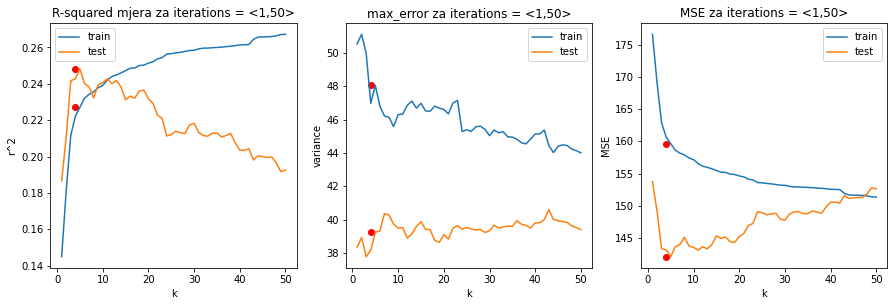

In [40]:
maximumTE = np.max(treeScoresTest1)
minimumTR = np.max(treeScoresTrain1)

print("Max test: " + str(round(maximumTE,3)) )
print("Max train:" + str(round(minimumTR,3)) )

index_of_maximum = np.where(treeScoresTest1 == maximumTE)[0][0]
print("Max test index:" + str(index_of_maximum) )


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

train=[treeScoresTrain1,treeScoresTrain2,treeScoresTrain3]
test=[treeScoresTest1,treeScoresTest2,treeScoresTest3]
labels=["r^2","variance","MSE"]
titles=[f"R-squared mjera za iterations = <1,{k}>",f"max_error za iterations = <1,{k}>",f"MSE za iterations = <1,{k}>"]

for i in range(3):
    tr= train[i]
    ts= test[i]
    ylab=labels[i]
    title=titles[i]
    
    ax[i].plot(index_of_maximum,tr[index_of_maximum],'ro')
    ax[i].plot(index_of_maximum,ts[index_of_maximum],'ro')
    
    ax[i].plot(np.arange(1,k+1),tr,label='train')
    ax[i].plot(np.arange(1,k+1),ts,label='test')
    
    ax[i].set(xlabel='k')
    ax[i].set(ylabel=ylab)
    ax[i].title.set_text(title)
    ax[i].legend()




plt.show()

### Najbolji hiperparametar $iterations$ nađen

In [41]:


model = CatBoostRegressor(iterations=index_of_maximum,
                          learning_rate=1,
                          depth=2)

model_FS = CatBoostRegressor(iterations=index_of_maximum,
                          learning_rate=1,
                          depth=2)

model.fit(train_data, train_labels)
model_FS.fit(X_train_FS, train_labels)

pred = model.predict(eval_data)
pred_FS = model_FS.predict(X_test_FS)

0:	learn: 13.2903056	total: 544us	remaining: 1.63ms
1:	learn: 13.0054013	total: 1.09ms	remaining: 1.09ms
2:	learn: 12.7612942	total: 1.63ms	remaining: 543us
3:	learn: 12.6764159	total: 2.22ms	remaining: 0us
0:	learn: 13.8423878	total: 575us	remaining: 1.73ms
1:	learn: 13.6663550	total: 1.13ms	remaining: 1.13ms
2:	learn: 13.5925662	total: 1.57ms	remaining: 525us
3:	learn: 13.4319034	total: 2.1ms	remaining: 0us


In [42]:
print("\nScores:")
data.loc['CATBoost'] = evaluateRegressor(y_test, pred)
data.loc['CATBoost_FS'] = evaluateRegressor(y_test, pred_FS)


Scores:
Test set evaluation:
MSE: 143.1515985001399
MAE: 9.491702720459843
RMSE: 11.964597715767125
R-squared: 0.24275685179845052 , from <0,1> 
Test set evaluation:
MSE: 163.15939514941093
MAE: 10.135386045125152
RMSE: 12.773386205286792
R-squared: 0.13691963389790707 , from <0,1> 


## Slučajne šume

### Pretraživanje hiperparametra: $n\_estimators$

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,max_error

In [44]:
k=50

treeScoresTest1=np.zeros(k)
treeScoresTrain1=np.zeros(k)
treeScoresTest2=np.zeros(k)
treeScoresTrain2=np.zeros(k)
treeScoresTest3=np.zeros(k)
treeScoresTrain3=np.zeros(k)



#X_train, X_test, y_train, y_test 


for k in np.arange(1,k+1):
    rf = RandomForestRegressor(n_estimators=k)
    rf.fit(X_train,y_train)
    treeScoresTrain1[k-1]=r2_score(y_train, rf.predict(X_train))
    treeScoresTest1[k-1] =r2_score(y_test, rf.predict(X_test))
    treeScoresTrain2[k-1]= max_error(y_train, rf.predict(X_train))
    treeScoresTest2[k-1] = max_error(y_test, rf.predict(X_test))
    treeScoresTrain3[k-1]= mean_squared_error (y_train, rf.predict(X_train))
    treeScoresTest3[k-1] = mean_squared_error (y_test, rf.predict(X_test))

Max test: 0.093
Max train:0.394
Max test index:29


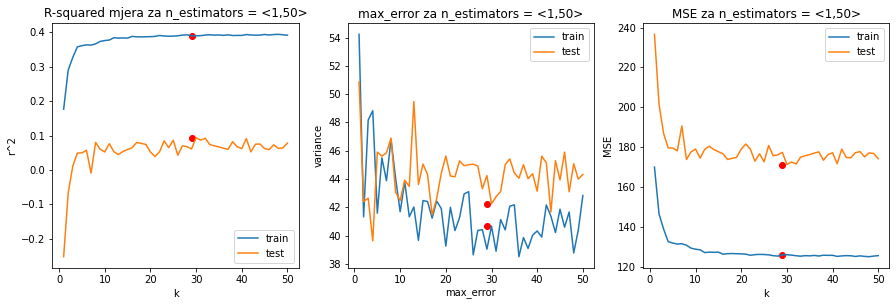

In [45]:

maximumTE = np.max(treeScoresTest1)
minimumTR = np.max(treeScoresTrain1)

print("Max test: " + str(round(maximumTE,3)) )
print("Max train:" + str(round(minimumTR,3)) )

index_of_maximum = np.where(treeScoresTest1 == maximumTE)[0][0]
print("Max test index:" + str(index_of_maximum) )


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))


ax[0].plot(index_of_maximum,treeScoresTrain1[index_of_maximum],'ro')
ax[0].plot(index_of_maximum,treeScoresTest1[index_of_maximum],'ro')
ax[0].plot(np.arange(1,k+1),treeScoresTrain1,label='train')
ax[0].plot(np.arange(1,k+1),treeScoresTest1,label='test')
ax[0].set(xlabel='k', ylabel='r^2')
ax[0].title.set_text(f"R-squared mjera za n_estimators = <1,{k}>")
ax[0].legend()

ax[1].plot(index_of_maximum,treeScoresTrain2[index_of_maximum],'ro')
ax[1].plot(index_of_maximum,treeScoresTest2[index_of_maximum],'ro')

ax[1].plot(np.arange(1,k+1),treeScoresTrain2,label='train')
ax[1].plot(np.arange(1,k+1),treeScoresTest2,label='test')
ax[1].set(xlabel='max_error', ylabel='variance')
ax[1].title.set_text(f"max_error za n_estimators = <1,{k}>")
ax[1].legend()

ax[2].plot(index_of_maximum,treeScoresTrain3[index_of_maximum],'ro')
ax[2].plot(index_of_maximum,treeScoresTest3[index_of_maximum],'ro')

ax[2].plot(np.arange(1,k+1),treeScoresTrain3,label='train')
ax[2].plot(np.arange(1,k+1),treeScoresTest3,label='test')
ax[2].set(xlabel='k', ylabel='MSE')
ax[2].title.set_text(f"MSE za n_estimators = <1,{k}>")
ax[2].legend()


plt.show()



### Našli smo $\text{n_estimators}$ koji daje najmanju grešku nad $test$ skupom:

In [46]:
rf = RandomForestRegressor(n_estimators=index_of_maximum)
rf.fit(X_train,y_train)

rf_FS = RandomForestRegressor(n_estimators=index_of_maximum)
rf_FS.fit(X_train_FS,y_train)
# Predictions
predictions = rf.predict(X_test)
predictions_FS = rf_FS.predict(X_test_FS)

In [47]:

data.loc['RF'] =evaluateRegressor(y_test, predictions)

data.loc['RF_FS'] =evaluateRegressor(y_test, predictions_FS)

Test set evaluation:
MSE: 177.63925303492795
MAE: 10.564131011483905
RMSE: 13.3281376431566
R-squared: 0.06032409961381591 , from <0,1> 
Test set evaluation:
MSE: 187.10060236996026
MAE: 10.673793054686648
RMSE: 13.67847222353287
R-squared: 0.010275465635848136 , from <0,1> 


### Koji atributi doprinose najviše modelu slučajnih šuma

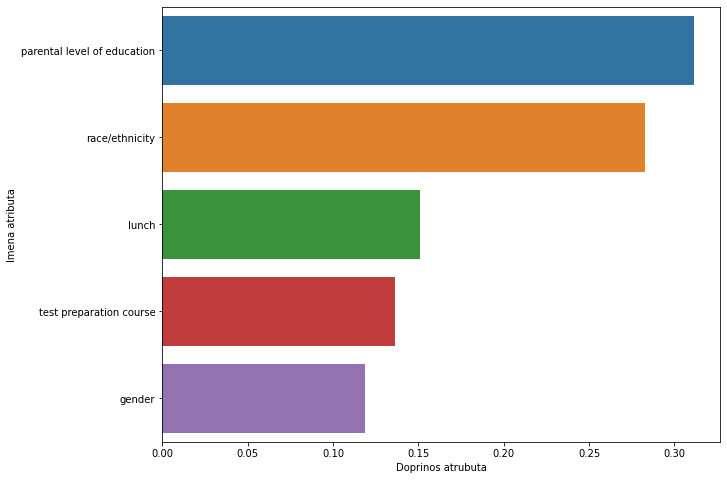

In [48]:
feature_importance = np.array(rf.feature_importances_)
feature_names = np.array(X_train.columns)
data2={'feature_names':feature_names,'feature_importance':feature_importance}
df_plt = pd.DataFrame(data2)
df_plt.sort_values(by=['feature_importance'], ascending=False,inplace=True)
plt.figure(figsize=(10,8))
sns.barplot(x=df_plt['feature_importance'], y=df_plt['feature_names'])
plt.xlabel('Doprinos atrubuta')
plt.ylabel('Imena atributa')
plt.show()

## SVM

In [49]:
from sklearn.svm import SVR
def SV_reg(kernel,X_train, y_train):
    model=SVR(kernel)
    model.fit(X_train, y_train)
    return model


SVM_model= SV_reg("linear",X_train, y_train)
pred_linear = SVM_model.predict(X_test)
linear_rmse = np.sqrt(mean_squared_error(y_test,pred_linear))

SVM_model= SV_reg("poly",X_train, y_train)
pred_poly = SVM_model.predict(X_test)
poly_rmse = np.sqrt(mean_squared_error(y_test,pred_poly))

SVM_model= SV_reg("sigmoid",X_train, y_train)
pred_sigmoid = SVM_model.predict(X_test)
sigmoid_rmse = np.sqrt(mean_squared_error(y_test,pred_sigmoid))

SVM_model= SV_reg("rbf",X_train, y_train)
pred_rbf = SVM_model.predict(X_test)
rbf_rmse = np.sqrt(mean_squared_error(y_test,pred_rbf))



data2 = {"kernel":pd.Series(["linear","polynomial","sigmoid","rbf"]),
            "Test RMSE":pd.Series([linear_rmse,poly_rmse,sigmoid_rmse,rbf_rmse])}
table_rmse=pd.DataFrame(data2)
table_rmse

,kernel,Test RMSE
0,linear,11.940368
1,polynomial,12.430719
2,sigmoid,23.427347
3,rbf,12.365359


### Umjesto ručnog pretraživanja hiperparametara $C$ i $\text{gamma}\ \gamma$ , koristimo funkciju $GridSearchCV$ za traženje hp. za 3 jezgrene fje. s najmanjom greškom

In [50]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

K = 15
#parameters = [{'kernel': ['linear','polynomial','rbf'], 'gamma': [2e-2, 2e-1, 1,  8],'C': [2e-3,2e-2, 2, 4]}]
#scorer = make_scorer(mean_squared_error, greater_is_better=False)
#svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

#svr_gs.fit(X_train, y_train)
#print(svr_gs.best_params_)

 Naći čemo npr. {'C': 2, 'gamma': 0.002, 'kernel': 'linear'}

In [52]:
regressor = SVR(C=2,gamma=0.002,kernel='linear')
regressor_FS = SVR(C=2,gamma=0.002,kernel='linear')
#regressor = SVR(**svr_gs.best_params_)
regressor.fit(X_train,y_train)
regressor_FS.fit(X_train_FS,y_train)

pred=regressor.predict(X_test)
pred_FS=regressor_FS.predict(X_test_FS)

In [53]:
data.loc['SVR'] = evaluateRegressor(y_test,pred)
data.loc['SVR_FS'] = evaluateRegressor(y_test,pred_FS)

Test set evaluation:
MSE: 142.37735990211135
MAE: 9.474374379735934
RMSE: 11.932198452176001
R-squared: 0.24685241817404868 , from <0,1> 
Test set evaluation:
MSE: 158.8164806795
MAE: 9.926726695859006
RMSE: 12.602241097499284
R-squared: 0.15989277747452046 , from <0,1> 


# DoWhy kauzalna analiza

## Priprema podataka

In [54]:
data_X_labeled= encode_data(df,enc_type="LABEL")
data_y_labeled= pd.cut(Y,
       5, labels=[1,2,3,4,5])

spojeno = pd.concat([data_X_labeled, data_y_labeled], axis=1)

In [55]:
spojeno.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'AVERAGE'],
      dtype='object')

## Analiza

In [56]:
import dowhy
from dowhy import CausalModel

In [57]:
model=CausalModel(
        data = spojeno,
        treatment='lunch',
        outcome='AVERAGE',
        common_causes=['gender','test preparation course', 'parental level of education','race/ethnicity']
        )

In [58]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|test preparation course,gender,race/ethnicity,par
d[lunch]                                                                      

                          
ental level of education))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,test preparation course,gender,race/ethnicity,parental level of education,U) = P(AVERAGE|lunch,test preparation course,gender,race/ethnicity,parental level of education)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [59]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))
data_1 = spojeno[spojeno["lunch"]==1]
data_0 = spojeno[spojeno["race/ethnicity"]==0]
print("ATE", np.mean(data_1["AVERAGE"].cat.codes)- np.mean(data_0["AVERAGE"].cat.codes))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|test preparation course,gender,race/ethnicity,par
d[lunch]                                                                      

                          
ental level of education))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,test preparation course,gender,race/ethnicity,parental level of education,U) = P(AVERAGE|lunch,test preparation course,gender,race/ethnicity,parental level of education)

## Realized estimand
b: AVERAGE~lunch+test preparation course+gender+race/ethnicity+parental level of education
Target units: ate

## Estimate
Mean value: 0.4816946592459539
p-value: [5.06520702e-22]

Causal Estimate is 0.4816946592459539
ATE 0.4540545248671717


Refute koraci:

In [60]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:0.4816946592459539
New effect:0.4818407421365949



Adding a random common cause didn’t have much of an effect on the causal effect (as expected) and so we can be more assured of the strength of the causal relationship.

# Rezultati & zaključak

Usporedimo rezultate koje smo dobili:

In [61]:
data

,MSE,MAE,RMSE,R^2
linearna,141.855872,9.469450,11.910326,0.249611
linearna_fs,160.356743,9.939536,12.663204,0.151745
Multi-Lasso,162.921172,10.427904,12.756507,0.260724
LightGBM,161.466927,10.043984,12.706964,0.145872
LightGBM_FS,180.909725,10.592236,13.450269,0.043024
kNN,155.008653,9.817593,12.450247,0.180035
kNN_FS,172.199140,10.438210,13.122467,0.089101
CATBoost,143.151599,9.491703,11.964598,0.242757
CATBoost_FS,163.159395,10.135386,12.773386,0.136920
RF,177.639253,10.564131,13.328138,0.060324


    U svim modelima predviđeni rezultati imaju dosta veliku grešku. To je možda zato što je skup malen te su atributi kategoričke varijable, te zato što dane varijable jednostavno nemaju nikakvu uzročno posljedičnu vezu oznakama ,tj. rezultatima ispita. Možda bi nam više pomogle varijable koje se odnose više na samog učenika, koliko je sati učio tjedno ili koliko je redovan na nastavi itd.